In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

In [29]:
rooth_path = 'data/'
deng_sj = pd.read_csv(rooth_path + 'deng_sj.csv')
deng_iq = pd.read_csv(rooth_path + 'deng_iq.csv')
test_sj = pd.read_csv(rooth_path + 'test_sj.csv')
test_iq = pd.read_csv(rooth_path + 'test_iq.csv')

In [30]:
time_sj = deng_sj.copy()
time_iq = deng_iq.copy()
dfs_time = [time_sj, time_iq]

In [31]:
# transform to feature week_start_date to datetime
def date_time(df):
    
    #setting a datetime index
    df.set_index('week_start_date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    return df

In [32]:
for df in dfs_time:
    df = date_time(df)

P-value: 5.1473186737591e-09


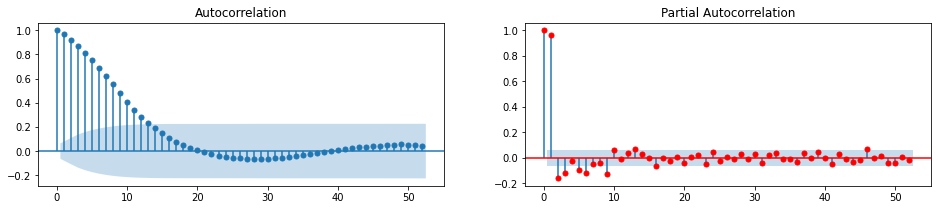

P-value: 1.0672522948401663e-07


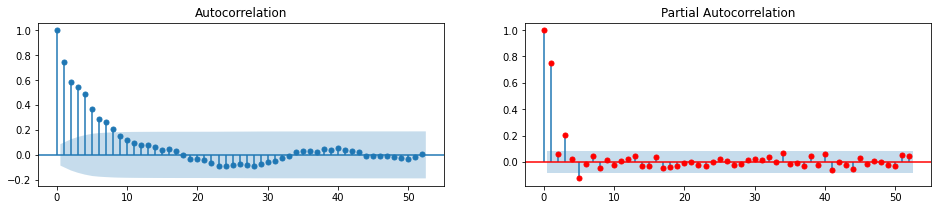

In [33]:
# Stationarity
for df in dfs_time:
    print(f'P-value: {adfuller(df.total_cases)[1]}') # p-value
    fig, axes = plt.subplots(1,2, figsize=(16,3))
    plot_acf(df.total_cases, lags=52, ax=axes[0]) # auto-correlation
    plot_pacf(df.total_cases, lags=52, ax=axes[1], color='r') # partial auto-correlation
    plt.show()

We can see that the p-value is close to 0 -> indicates stationarity

#### Covert Kelvin to Celsius
'reanalysis_air_temp_k','reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k'
'reanalysis_tdtr_k' -> There is no need to convert this feature, since is the difference between the maximum and minimum 

In [34]:
def convert_celsius(df):
    
    k = 273.15
    
    # convert to celsius
    df['reanalysis_air_temp_k'] -= k
    df['reanalysis_avg_temp_k'] -= k
    df['reanalysis_dew_point_temp_k'] -= k
    df['reanalysis_max_air_temp_k'] -= k
    df['reanalysis_min_air_temp_k'] -= k
    
    # change features names
    col = df.columns
    col = col.str.replace('temp_k', 'temp_c')
    df.columns = col.str.replace('tdtr_k', 'tdtr_c')
    
    return df

In [35]:
deng_sj = convert_celsius(deng_sj)
deng_iq = convert_celsius(deng_iq)
test_sj = convert_celsius(test_sj)
test_iq = convert_celsius(test_iq)

#### Mean of Normalized difference vegetation

In [36]:
def mean_ndvi(df):
    
    df['ndvi_mean'] = df[df.columns[3:7]].mean(axis = 1)
    
    return df

In [37]:
deng_sj = mean_ndvi(deng_sj)
deng_iq = mean_ndvi(deng_iq)
test_sj = mean_ndvi(test_sj)
test_iq = mean_ndvi(test_iq)

#### Feature selection
We will drop the features with > 0.95 correlation for a first model. 

In [38]:
def feature_selection(df, columns):
    
    df.drop(columns = columns, inplace=True)
    
    return df

In [39]:
deng_sj = feature_selection(deng_sj, ['reanalysis_air_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])
deng_iq = feature_selection(deng_iq, ['reanalysis_avg_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])
test_sj = feature_selection(test_sj, ['reanalysis_air_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])
test_iq = feature_selection(test_iq, ['reanalysis_avg_temp_c', 'reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_c'])

#### Rolling Features
Since the datasets (train and test) are continious, we will join the two in order to avoid having 0 values in the test set for the rolling averages. Then we will split accordingly

In [40]:
def rolling_feat(df, df_test, roll_win_size, city):
    
    # save total cases in a dataframe
    total_cases = df[['city', 'year', 'weekofyear', 'total_cases']]
    
    df.drop(columns=['total_cases'], inplace=True)
    
    total_df = pd.concat([df, df_test], axis=0)
    
    cols = total_df.columns[4:] #Features columns excluding week_start_date, city and weekofyear
    
    for col in cols:
        total_df[col + '_sum']  = total_df[col].rolling(roll_win_size).sum()
        total_df[col + '_av'] = total_df[col].rolling(roll_win_size).mean()
        total_df[col + '_var']  = total_df[col].rolling(roll_win_size).var()
        
    # Split train-test again
    
    if city == 'San Juan':
        df_ = total_df[total_df.week_start_date < '2008-04-29']
        df_test = total_df[total_df.week_start_date >= '2008-04-29']
    
    if city == 'Iquitos':
        df_ = total_df[total_df.week_start_date < '2010-07-02']
        df_test = total_df[total_df.week_start_date >= '2010-07-02']
    
    df_ = df_.merge(total_cases, on=['city', 'year', 'weekofyear'])
      
    df_.dropna(axis=0, inplace=True) #trim rows with null values of rolling features
    
    return df_, df_test

In [41]:
deng_sj_train, test_sj = rolling_feat(deng_sj, test_sj, 4, 'San Juan')
deng_iq_train, test_iq = rolling_feat(deng_iq, test_iq, 4, 'Iquitos')

#### Fix skewenes

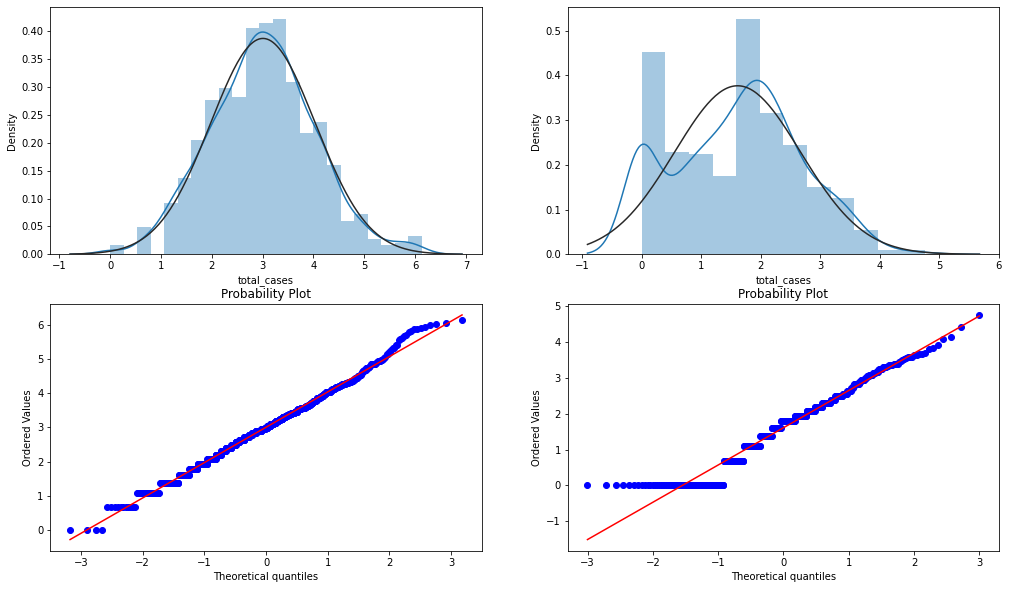

In [42]:
# Target Variable
deng_sj_train["total_cases"] = np.log1p(deng_sj_train["total_cases"])
deng_iq_train["total_cases"] = np.log1p(deng_iq_train["total_cases"])
plt.figure(figsize=(17,10))
plt.subplot(2,2,1)
sns.distplot(deng_sj_train.total_cases, fit=norm)
plt.subplot(2,2,2)
sns.distplot(deng_iq_train.total_cases, fit=norm)
plt.subplot(2,2,3)
stats.probplot(deng_sj_train['total_cases'], plot=plt)
plt.subplot(2,2,4)
stats.probplot(deng_iq_train['total_cases'], plot=plt)
plt.show()

Although it is not perfect we will proceed from here

In [43]:
# Skewed features for SJ
numeric_feats = deng_sj_train.columns[4:-1]

# Check the skew of all numerical features
skewed_feats = deng_sj_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
reanalysis_precip_amt_kg_per_m2_var,12.717491
station_precip_mm_var,7.691967
ndvi_ne_var,5.972046
precipitation_amt_mm_var,5.904148
reanalysis_precip_amt_kg_per_m2,5.567206
ndvi_mean_var,3.930948
ndvi_nw_var,3.836058
reanalysis_min_air_temp_c_var,3.174419
station_precip_mm,2.630462
precipitation_amt_mm,2.605521


In [44]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    deng_sj_train[feat] = boxcox1p(deng_sj_train[feat], lam)

In [45]:
deng_sj_train

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_avg_temp_c,...,station_min_temp_c_sum,station_min_temp_c_av,station_min_temp_c_var,station_precip_mm_sum,station_precip_mm_av,station_precip_mm_var,ndvi_mean_sum,ndvi_mean_av,ndvi_mean_var,total_cases
3,1990-05-21,sj,1990,21,0.122112,0.222832,0.208211,0.215188,3.471892,4.267926,...,6.411187,4.008631,1.239116,5.968981,3.660579,8.850804,3.856228,2.053772,0.108382,1.386294
4,1990-05-28,sj,1990,22,0.181579,0.236971,0.227912,0.224718,2.526702,4.294139,...,6.495310,4.075107,0.434472,5.678424,3.433368,9.137154,3.935177,2.111158,0.119068,1.945910
5,1990-06-04,sj,1990,23,0.145271,0.163104,0.230484,0.169099,2.830227,4.300105,...,6.531046,4.103369,0.253513,6.454709,4.043013,9.823879,4.007885,2.164265,0.115732,1.098612
6,1990-06-11,sj,1990,24,0.107832,0.089336,0.189173,0.193603,1.681679,4.267493,...,6.541453,4.111602,0.114297,6.187553,3.832305,9.067416,4.076871,2.214872,0.087289,1.609438
7,1990-06-18,sj,1990,25,0.070361,0.070361,0.142543,0.126071,7.498989,4.286012,...,6.531046,4.103369,0.253513,6.568296,4.132842,8.104062,4.137720,2.259680,0.074437,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,2008-03-25,sj,2008,13,0.075391,-0.040594,0.275945,0.264586,4.334101,4.125167,...,6.337529,3.950490,0.386965,3.836114,2.039200,4.577045,3.076958,1.506147,0.131961,1.609438
932,2008-04-01,sj,2008,14,-0.038628,-0.016955,0.113726,0.064586,1.773787,4.206381,...,6.362345,3.970071,0.519519,2.474062,1.113384,1.653458,3.190181,1.583276,0.131805,1.386294
933,2008-04-08,sj,2008,15,-0.166540,-0.053973,0.130316,0.133410,3.614791,4.164380,...,6.351098,3.961196,0.408567,4.672512,2.659527,8.334398,3.303179,1.661163,0.082204,0.693147
934,2008-04-15,sj,2008,16,0.001799,-0.031990,0.188173,0.193238,0.000000,4.178030,...,6.375768,3.980666,0.186977,5.141419,3.017378,8.040408,3.402635,1.730426,0.088990,1.386294


In [46]:
# Skewed features for IQ
numeric_feats = deng_iq_train.columns[4:-1]

# Check the skew of all numerical features
skewed_feats = deng_iq_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
station_max_temp_c_var,8.725819
station_precip_mm_var,6.689544
station_avg_temp_c_var,5.679907
ndvi_mean_var,3.924404
station_diur_temp_rng_c_var,3.319797
reanalysis_precip_amt_kg_per_m2_var,3.219398
reanalysis_specific_humidity_g_per_kg_var,3.174806
station_min_temp_c_var,2.716641
reanalysis_relative_humidity_percent_var,2.617392
station_precip_mm,2.218784


In [47]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    deng_iq_train[feat] = boxcox1p(deng_iq_train[feat], lam)

#### Encode Months of the year by quarters
By Feature Exploration we have seen a tendency of cases in the last Quarter of the year

In [48]:
def enc_quarters(df):
    
    df['week_start_date'] = pd.to_datetime(df.week_start_date)
    df['quarter'] = df['week_start_date'].dt.quarter
    
    df = pd.get_dummies(df, columns=['quarter'])
    
    return df

In [49]:
deng_sj_train = enc_quarters(deng_sj_train)
deng_iq_train = enc_quarters(deng_iq_train)
test_sj = enc_quarters(test_sj)
test_iq = enc_quarters(test_iq)

#### Split for train, validation and test

In [50]:
def split_df(df):
    
    split = df.shape[0] - df.shape[0]*0.1 # Split with train 90% and validation 10%
    
    df_train = df[df.index < split]
    df_val = df[df.index >= split]
    
    
    return df_train, df_val

In [51]:
deng_sj_train, deng_sj_val = split_df(deng_sj_train) #SJ split data in train-validation
deng_iq_train, deng_iq_val = split_df(deng_iq_train) #IQ split data in train-validation

In [24]:
# Save again to CSV's
deng_sj_train.to_csv('data/deng_sj_train.csv', index=False) # SJ Train
deng_iq_train.to_csv('data/deng_iq_train.csv', index=False) # IQ Train
deng_sj_val.to_csv('data/deng_sj_val.csv', index=False) # SJ Validation
deng_iq_val.to_csv('data/deng_iq_val.csv', index=False) # IQ Validation
test_sj.to_csv('data/test_sj_.csv', index=False) # SJ Test
test_iq.to_csv('data/test_iq_.csv', index=False) # IQ Test